**IMPORTANT NOTE**: We have worked with the Jupyter Notebook locally instead of using Google Colab.

Therefore, all the file paths are configured to work in a local installation of python.

# Ex. 1

**Steps** : 

  1. Load train.csv and test.csv containing a 2D dataset (features X and Y) with two different classes

  2. Visualize the dataset and normalize the dimensions of the samples to have zero mean and unit standard deviation

  3. Implement an MLP using Numpy in order to solve a classification problem trying to estimate the classes of the samples

  4. Train the MLP and visualize the decision boundary in 2D of the classification. Plot the training loss for each iteration.

  5. Use the learned MLP to estimate the classes of the data in test.csv. Compute the accuracy in training and testing dataset.

## Sol. 1

### Load data

In [1]:
import pandas as pd 
import numpy as np

save_figure = False # Change value if you want to save the plots.

seed_value = 43
np.random.seed(seed_value)

data_path = 'Data/'
results_path = 'Results/'

# Load training and testing data
train_data = pd.read_csv(data_path + "train.csv")
test_data = pd.read_csv(data_path + "test.csv")

X_train = train_data[["X", "Y"]].to_numpy(dtype=np.double)
C_train = train_data["C"].to_numpy(dtype=np.int32).reshape(-1, 1)

X_test = test_data[["X", "Y"]].to_numpy(dtype=np.double)
C_test = test_data["C"].to_numpy(dtype=np.int32).reshape(-1, 1)

### Visualise data

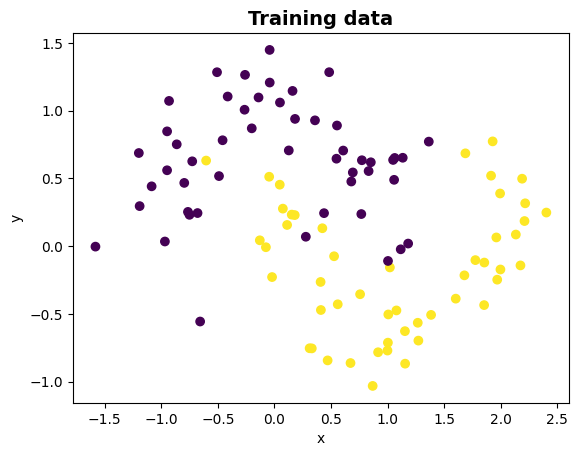

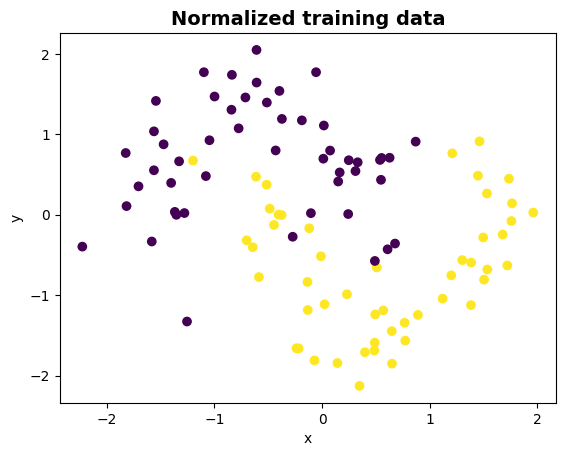

In [2]:
import matplotlib.pyplot as plt #  matplotlib for visualization

def normalize(X):
    """
    Z-score normalization
    """
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    return (X - mu) / sigma

# Visualize original data
fig1 = plt.figure(1)
plt.title("Training data", fontsize=14, fontweight="bold")
plt.scatter(X_train[:,0], X_train[:,1], c=C_train)
plt.xlabel("x")
plt.ylabel("y")
if save_figure:
    plt.savefig(f"{results_path}fig1.png", dpi=300)
plt.show()

# Normalize dataset
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

# Visualize normalized data
fig2 = plt.figure(2)
plt.title("Normalized training data", fontsize=14, fontweight="bold")
plt.scatter(X_train_norm[:,0], X_train_norm[:,1], c=C_train)
plt.xlabel("x")
plt.ylabel("y")
if save_figure:
    plt.savefig(f"{results_path}fig2.png", dpi=300)
plt.show()

### Implement MLP using numpy

In [3]:
class MLP(object):
    def __init__(self,inputNode=2,hiddenNode = 3, outputNode=1):        
        #Define MLP hyper-parameters
        self.inputLayerSize = inputNode # number of input dimensions (x)
        self.outputLayerSize = outputNode # number of output dimensions (y)
        self.hiddenLayerSize = hiddenNode # Dimension of intermediate layer (W_2)
        
        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
    def forward(self, X, update=True):
        #Compute inputs from outputs
        z2 = np.dot(X, self.W1)
        a2 = self.sigmoid(z2)
        z3 = np.dot(a2, self.W2)
        if update:
            self.z2 = z2
            self.a2 = a2
            self.z3 = z3
        yHat = self.sigmoid(z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    # Derivative of sigmoid and loss with respect their inputs
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def loss(self, yHat, y): # Cross entropy
        # Compute loss for given X,y, use weights already stored in class.
        H = np.multiply(-y, np.log(yHat)) - np.multiply((1-y), np.log(1-yHat))
        J = 1/y.size * np.sum(H) # CrossEntropy
        return J

    def lossPrime(self, yHat, y): # Cross entropy
        dJdyHat = np.divide(-y, yHat) + np.divide(1-y, 1-yHat)
        return dJdyHat
        
    # Derivative of parameters
    def backward(self, X, yHat, y):
        self.yHat = yHat
        
        delta3 = np.multiply(self.lossPrime(yHat, y), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)  
        return dJdW1,dJdW2


### Train MLP and visualise decision boundary

#### Train the network

In [4]:
def classify(NN, X):
    yHat = NN.forward(X, update=False)
    return yHat.round().astype(int)

In [5]:
def binary_classification_accuracy(x, y, y_pred):
    """
    Computes the accuracy based on the real output y and the predicted output of the NN y_pred
    """
    true0_pred0_points = x[(y[:,0] == 0) & (y_pred[:,0] == 0)]
    true1_pred1_points = x[(y[:,0] == 1) & (y_pred[:,0] == 1)]

    num_datapoints = len(x)
    accuracy = (len(true0_pred0_points) + len(true1_pred1_points)) / num_datapoints
    
    return accuracy

In [6]:
def train(NN, X_train, X_test, y_train, y_test, epoch = 10000, lr = .01):
    """
    This function takes both a training dataset and a test dataset to evaluate
    the performance of the neural network.
    """
    train_list_loss = []
    test_list_loss = []
    test_accuracy = []
    
    for i in range(epoch):
        # Forward pass
        yHat_test = NN.forward(X_test, update=False)
        yHat_train = NN.forward(X_train)

        # Compute the Loss
        if i % 100 == 0:  
            train_loss = NN.loss(yHat_train, y_train)
            test_loss = NN.loss(yHat_test, y_test)
            train_list_loss.append(train_loss)
            test_list_loss.append(test_loss)

            y_pred = classify(NN, X_test)
            test_accuracy.append(binary_classification_accuracy(X_test, y_test, y_pred) * 100)
            
            

        # Compute derivative with respect to W and W2 for a given X and y:
        gradW1,gradW2 = NN.backward(X_train,yHat_train,y_train)

        # Update the parameters using gradient descent
        NN.W1 -= gradW1 * lr
        NN.W2 -= gradW2 * lr
        
    return train_list_loss, test_list_loss, test_accuracy

In [7]:
np.random.seed(seed_value)
NN = MLP(hiddenNode=20)
train_list_loss, test_list_loss, our_test_accuracy = train(NN, X_train_norm, X_test_norm, C_train, C_test, epoch=10000, lr=0.01)

#### Visualize the decision boundary

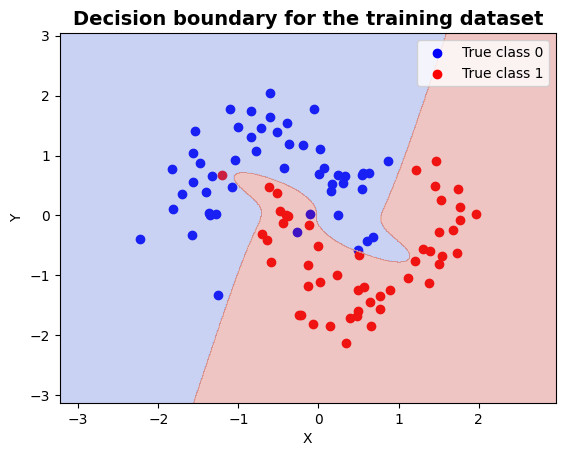

In [8]:
# Plot the training data as a scatter plot (for reference)
fig3 = plt.figure(3)
class_0_points = X_train_norm[C_train[:,0] == 0]
class_1_points = X_train_norm[C_train[:,0] == 1]
plt.scatter(class_0_points[:, 0], class_0_points[:, 1], color='blue', label='True class 0')
plt.scatter(class_1_points[:, 0], class_1_points[:, 1], color='red', label='True class 1')

def boundary_points(X, NN):
    """
    Returns grid points for plotting the decision boundary using plt.countourf
    """
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = classify(NN, grid_points)
    Z = Z.reshape(xx.shape)
    return xx, yy, Z

xx_train, yy_train, Z = boundary_points(X_train_norm, NN) 
plt.contourf(xx_train, yy_train, Z, alpha=0.3, cmap='coolwarm')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Decision boundary for the training dataset', fontsize=14, fontweight="bold")
plt.legend()
if save_figure:
    plt.savefig(f"{results_path}fig3.png", dpi=300)
plt.show()

### Plot the loss function

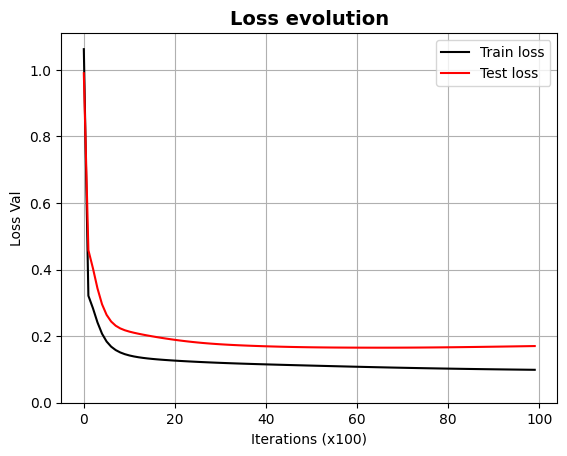

In [9]:
# Visualize loss function evolution
fig4 = plt.figure(4)
plt.title('Loss evolution', fontsize=14, fontweight="bold")
plt.plot(train_list_loss, color="black", label="Train loss")
plt.plot(test_list_loss, color="red", label="Test loss")
plt.xlabel('Iterations (x100)')
plt.ylabel('Loss Val')
plt.legend()
plt.ylim(0, None)
plt.grid()
if save_figure:
    plt.savefig(f"{results_path}fig4.png", dpi=300)
plt.show()


### Classify the data in test.csv using the trained MLP

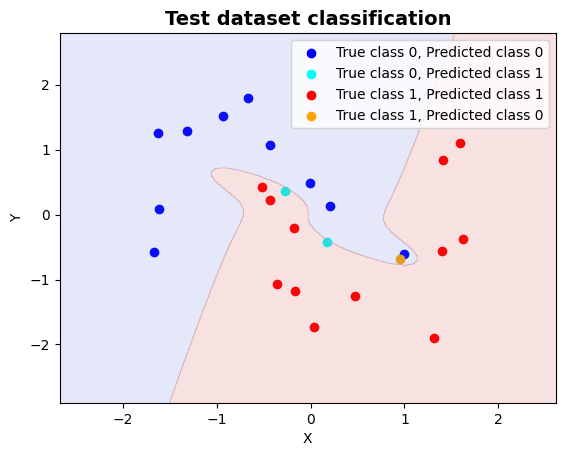

In [10]:
output_test = classify(NN, X_test_norm)
                                
true0_pred0_points = X_test_norm[(C_test[:,0] == 0) & (output_test[:,0] == 0)]
true0_pred1_points = X_test_norm[(C_test[:,0] == 0) & (output_test[:,0] == 1)]
true1_pred1_points = X_test_norm[(C_test[:,0] == 1) & (output_test[:,0] == 1)]
true1_pred0_points = X_test_norm[(C_test[:,0] == 1) & (output_test[:,0] == 0)]

fig5 = plt.figure(5)
plt.scatter(true0_pred0_points[:, 0], true0_pred0_points[:, 1], color='blue', label='True class 0, Predicted class 0')
plt.scatter(true0_pred1_points[:, 0], true0_pred1_points[:, 1], color='cyan', label='True class 0, Predicted class 1')
plt.scatter(true1_pred1_points[:, 0], true1_pred1_points[:, 1], color='red', label='True class 1, Predicted class 1')
plt.scatter(true1_pred0_points[:, 0], true1_pred0_points[:, 1], color='orange', label='True class 1, Predicted class 0')

xx_test, yy_test, Z_test = boundary_points(X_test_norm, NN)
plt.contourf(xx_test, yy_test, Z_test, alpha=0.15, cmap='coolwarm')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Test dataset classification', fontsize=14, fontweight="bold")
plt.legend()
if save_figure:
    plt.savefig(f"{results_path}fig5.png", dpi=300)
plt.show()

### Compute the accuracy in the training and testing dataset

In [11]:
output_train = classify(NN, X_train_norm)

train_accuracy = binary_classification_accuracy(X_train_norm, C_train, output_train)
print(f"\nTrain accuracy: {train_accuracy*100}%")

print(f"\nTest accuracy: {our_test_accuracy[-1]}%")


Train accuracy: 97.0%

Test accuracy: 88.0%


# Ex. 2

Instead of using the implemented optimizer with standard Gradient Descent, in this exercice you will use SGD with momentum. 
This optimizer tipically accelerates the convergence of the optimization and, thus, it reduce the number of iterations during gradient-descent.

**Steps** : 

  1. Try to understand how momentum is implemented reading carefully https://ruder.io/optimizing-gradient-descent/index.html#momentum, or https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d

  2. Modifying OptimSGD in the examples, implement SGD with momentum in a new class call OptimMom. 

  3. Train the MLP implmented in numpy with this new optimizer. 

  4. Use different values for the momentum paramter `[0,1]` and plot the evolution of the training loss during gradient-descent. Compare the results using the different values and standard gradient descent.

## Sol. 2

### Implement SGD with momentum

In [12]:
class OptimMom(object):
    def __init__(self, learning_rate = .01, beta = .9):
        self.lr = learning_rate
        self.beta = beta
        self.vt_previous = [] # Store a separate vt for each layer

    # receive the parameters of the MLP and the computed gradients and update the latter
    def step(self,weight_list, gradient):
        uw = []

        if len(self.vt_previous) == 0:
            self.init_vt(weight_list)
        
        # Update parameter using vt[t-1] of the corresponding layer
        i = 0
        for w, grd in zip(weight_list, gradient):
            vt = self.beta * self.vt_previous[i] + self.lr * grd
            uw.append(w - vt)
            self.vt_previous[i] = vt
            i += 1
            
        return uw
    
    def init_vt(self, weight_list):
        """
        Initialize velocities to 0
        """
        for w in weight_list:
            self.vt_previous.append(np.zeros(w.shape))

### Train the MLP using the new optimizer

In [13]:
# Same training procedure than before but using the optimizer class
def train_woptimizer(NN, X, y, epoch = 5000, optim = None):
    """
    In this case we do not evaluate the performance of the test dataset, since
    the goal of the exercise is to compare the training performance between
    using momentum and not using it.
    """
    list_loss = []
    
    for i in range(epoch):
        # Forward pass
        yHat = NN.forward(X)
        
        # Compute the loss
        if i % 100 == 0: 
            loss = NN.loss(yHat,y)
            list_loss.append(loss)

        # Compute derivative with respect to W and W2 for a given X and y:
        gradW1, gradW2 = NN.backward(X, yHat, y)

        # Now update the weight using the optimizer class
        NN.W1, NN.W2 = optim.step([NN.W1,NN.W2],[gradW1,gradW2])
        
    return list_loss

In [14]:
np.random.seed(seed_value)
NN_momentum = MLP(hiddenNode=20)
optimizer = OptimMom(learning_rate=0.01, beta=0.9)
momentum_list_loss = train_woptimizer(NN_momentum, X_train_norm, C_train, epoch=10000, optim=optimizer)

### Visualize the loss function and compare it with standard SGD

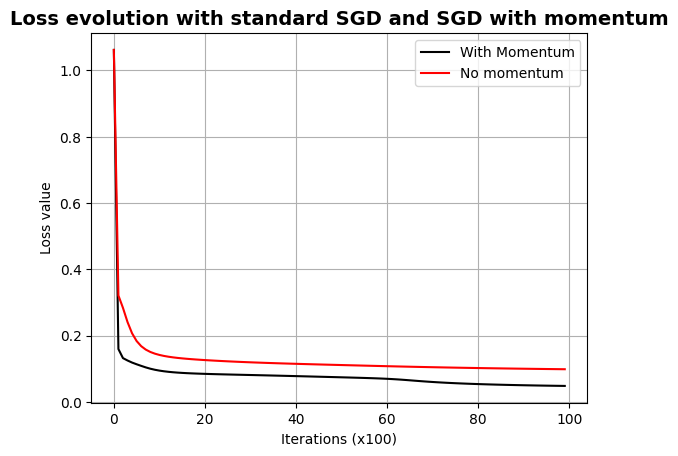

In [15]:
fig6 = plt.figure(6)

plt.plot(momentum_list_loss, color="black", label="With Momentum")
plt.plot(train_list_loss, color="red", label="No momentum")
plt.title("Loss evolution with standard SGD and SGD with momentum", fontsize=14, fontweight="bold")
plt.xlabel('Iterations (x100)')
plt.ylabel("Loss value")
plt.grid()
plt.legend()
if save_figure:
    plt.savefig(f"{results_path}fig6.png", dpi=300)
plt.show()


### Try different $\beta$ values and visualize the loss function

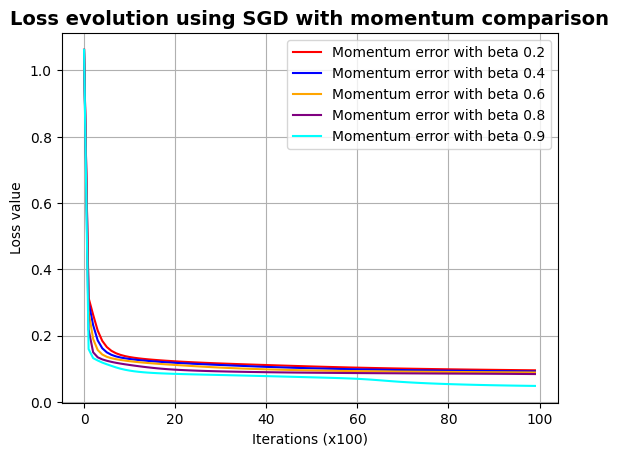

In [16]:
## Tests for different values of beta
## We can do it this way since we are using a fixed random seed
fig7 = plt.figure(7)
betas = [0.2, 0.4, 0.6, 0.8, 0.9]
colors = ["red", "blue", "orange", "purple", "cyan"]
assert len(betas) == len(colors)
losses = {}

#Train network with the data:
for b in betas:
    np.random.seed(seed_value)
    NN_momentum = MLP(hiddenNode=20)
    temp_loss = train_woptimizer(NN_momentum, X_train_norm, C_train, epoch=10000, optim=OptimMom(learning_rate=0.01, beta=b))
    losses[b] = temp_loss

i = 0
for beta in losses:
    col = (np.random.random(), np.random.random(), np.random.random())
    plt.plot(losses[beta], color=colors[i], label=f"Momentum error with beta {beta}")
    i += 1

plt.title("Loss evolution using SGD with momentum comparison", fontsize=14, fontweight="bold")
plt.xlabel('Iterations (x100)')
plt.ylabel("Loss value")
plt.grid()
plt.legend()
if save_figure:
    plt.savefig(f"{results_path}fig7.png", dpi=300)
plt.show()

# Ex. 3

**Steps** : 

  1. Do the same as Ex. 1 but implementing the `MLP` using `PyTorch`.

  2. Train different vesions of the `MLP` by varying the number of hidden neurons and learing rates

  3. Analyse the results in each case and discuss them.

> HINT: Check in https://pytorch.org/docs/stable/nn.html what loss function implemented in `PyTorch` you have to use in this case.

## Sol. 3

### Implement the MLP using PyTorch

In [17]:
import torch.nn as nn
import torch

class MLP_PyTorch(nn.Module):
    def __init__(self, inputNode=2, hiddenNode=3, outputNode=1):   
        super(MLP_PyTorch, self).__init__()    

        # Define Hyperparameters
        self.inputLayerSize = inputNode
        self.hiddenLayerSize = hiddenNode
        self.outputLayerSize = outputNode
        
        # Initialize two modules implementing the two linear layers of the MLP
        self.linear_layer1 = nn.Linear(self.inputLayerSize, self.hiddenLayerSize) 
        self.linear_layer2 = nn.Linear(self.hiddenLayerSize, self.outputLayerSize)
        
        self.activation_fun = nn.Sigmoid() # Module implementing the sigmoid funciton
        self.loss = nn.BCELoss() # Module implementing the mean-squared error loss

    # Define the forward pass of the module using the sub-modules declared in the initializer
    def forward(self, X):
        z1 = self.linear_layer1(X) # First Linear Layer   
        a1 = self.activation_fun(z1) # activation function
        z2 = self.linear_layer2(a1) # Second Linear Layer   
        a2 = self.activation_fun(z2) # final activation function (y_Hat)
        return a2

#### Train the MLP using PyTorch

In [18]:
def torch_classify(NN, X):
    with torch.no_grad():
        yHat = NN.forward(torch.from_numpy(X).float())
    return yHat.numpy().round().astype(int)

In [19]:
import time

# Function to train our MLP with PyTorch
def train_PyTorch(NN, X_train, X_test, y_train, y_test, epoch = 10000, lr = .01, optimizer = None):
    """
    This function takes both a training dataset and a test dataset to evaluate
    the performance of the neural network.
    """
    train_list_loss = []
    test_list_loss = []
    cum_time = [] # Cumulative time at each iteration. Used for performance evaluation
    test_accuracy = []

    for i in range(epoch):
        # Evaluate the test dataset
        with torch.no_grad():
            yHat_test = NN.forward(X_test)
            test_loss_val = NN.loss(yHat_test, y_test)

        # reset optimizer at each epoch to not accumulate gradient from previous steps, as we train in batches
        optimizer.zero_grad()

        # Perform a training iteration. Store the computation time
        start_time = time.time()

        yHat_train = NN.forward(X_train) # Process dataset with forward pass
        train_loss_val = NN.loss(yHat_train, y_train) # Compute the loss
        train_loss_val.backward() # Automatically compute the gradients
        optimizer.step() # Call the optimizer to update the paramters

        end_time = time.time()
        elapsed_time = end_time - start_time

        # Print loss and save the value at each iteration
        if i % 100 == 0: 
            # print('Loss {}={}'.format(i,train_loss_val))
            train_list_loss.append(train_loss_val.item())
            test_list_loss.append(test_loss_val.item())
            cum_time.append(elapsed_time)
            
            # Compute the accuracy for the testing dataset
            with torch.no_grad():
                y_pred = torch_classify(NN, X_test.numpy())
                test_accuracy.append(binary_classification_accuracy(X_test.numpy(), y_test.numpy(), y_pred) * 100)
    
    return train_list_loss, test_list_loss, cum_time, test_accuracy

In [20]:
torch.manual_seed(seed_value)

# Initialize a Pytorch MLP
NN = MLP_PyTorch(hiddenNode=20) 
optimizer = torch.optim.SGD(NN.parameters(), lr=.01, momentum=0.0) 

#Train MLP using Pytorch:
torch_train_list_loss, torch_test_list_loss, _, torch_accuracy = train_PyTorch(
    NN,
    torch.from_numpy(X_train_norm).type(NN.parameters().__next__().dtype),
    torch.from_numpy(X_test_norm).type(NN.parameters().__next__().dtype),
    torch.from_numpy(C_train).type(NN.parameters().__next__().dtype),
    torch.from_numpy(C_test).type(NN.parameters().__next__().dtype),
    optimizer = optimizer
)

#### Compare the results with numpy implementation of exercise 1

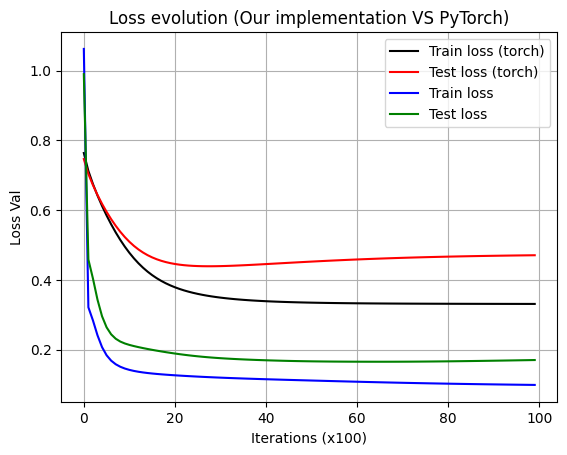

In [21]:
# Plot the evolution of the loss function during training
fig8 = plt.figure(8)
plt.plot(torch_train_list_loss, color = "black", label = "Train loss (torch)")
plt.plot(torch_test_list_loss, color = "red", label = "Test loss (torch)")
plt.plot(train_list_loss, color = "blue", label = "Train loss")
plt.plot(test_list_loss, color = "green", label = "Test loss")
plt.title("Loss evolution (Our implementation VS PyTorch)")
plt.xlabel('Iterations (x100)')
plt.ylabel('Loss Val')
plt.legend()
plt.grid()
if save_figure:
    plt.savefig(f"{results_path}/fig8.png", dpi=300)
plt.show()

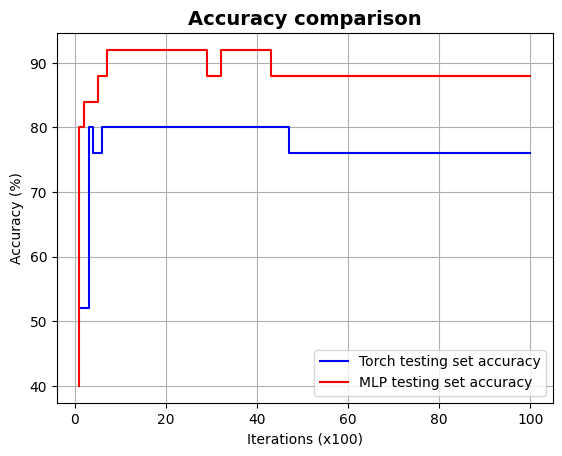

In [22]:
fig11 = plt.figure()
plt.step(np.arange(1, len(torch_accuracy) + 1, 1), torch_accuracy, color="blue", label="Torch testing set accuracy")
plt.step(np.arange(1, len(our_test_accuracy) + 1, 1), our_test_accuracy, color="red", label="MLP testing set accuracy")
plt.xlabel('Iterations (x100)')
plt.ylabel("Accuracy (%)")
plt.title("Accuracy comparison", fontsize=14, fontweight="bold")
plt.legend()
plt.grid()
if save_figure:
    plt.savefig(f"{results_path}/fig11.png", dpi=300)
plt.show()

### Try different number of hidden neurons



Tests for different number of hidden neurons:
	3 neurons: Iterations to min error (0.45741352438926697): 69. Time to min error: 0.0005707740783691406(s)
	7 neurons: Iterations to min error (0.46026480197906494): 49. Time to min error: 0.00023221969604492188(s)
	12 neurons: Iterations to min error (0.45771872997283936): 40. Time to min error: 0.0002338886260986328(s)
	15 neurons: Iterations to min error (0.4470718502998352): 31. Time to min error: 0.0002980232238769531(s)
	18 neurons: Iterations to min error (0.4463762640953064): 28. Time to min error: 0.00023818016052246094(s)
	20 neurons: Iterations to min error (0.4425450563430786): 27. Time to min error: 0.00023698806762695312(s)
	50 neurons: Iterations to min error (0.442948579788208): 18. Time to min error: 0.00026226043701171875(s)
	100 neurons: Iterations to min error (0.4383326470851898): 11. Time to min error: 0.00038695335388183594(s)


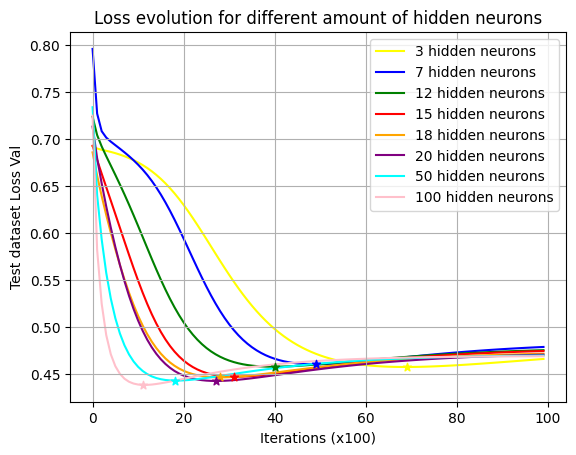

In [23]:
hidden_neurons = [3, 7, 12, 15, 18, 20, 50, 100]
custom_colors = ['yellow', 'blue', 'green', 'red', 'orange', 'purple', 'cyan', 'pink', 'black']
torch.manual_seed(10)

print("\n\nTests for different number of hidden neurons:")
fig9 = plt.figure(9)

for neuron, color in zip(hidden_neurons, custom_colors):
    curr_NN = MLP_PyTorch(hiddenNode=neuron)
    curr_optimizer = torch.optim.SGD(curr_NN.parameters(), lr=.01, momentum=0) 
    torch_train_list_loss, torch_test_list_loss, train_time, _ = train_PyTorch(
        curr_NN,
        torch.from_numpy(X_train_norm).type(curr_NN.parameters().__next__().dtype),
        torch.from_numpy(X_test_norm).type(curr_NN.parameters().__next__().dtype),
        torch.from_numpy(C_train).type(curr_NN.parameters().__next__().dtype),
        torch.from_numpy(C_test).type(curr_NN.parameters().__next__().dtype),
        optimizer = curr_optimizer
    )   
    
    argmin = torch_test_list_loss.index(min(torch_test_list_loss))
    print(f"\t{neuron} neurons: Iterations to min error ({torch_test_list_loss[argmin]}): {argmin}. Time to min error: {train_time[argmin]}(s)")
    plt.scatter(argmin, torch_test_list_loss[argmin], color = color, marker="*", zorder = 2)
    plt.plot(torch_test_list_loss, color = color, label = f"{neuron} hidden neurons", zorder = 1)

plt.title("Loss evolution for different amount of hidden neurons")
plt.xlabel('Iterations (x100)')
plt.ylabel('Test dataset Loss Val')
plt.legend()
plt.grid()
if save_figure:
    plt.savefig(f"{results_path}/fig9.png", dpi=300)
plt.show()

### Try different learning rates



Tests for different learning rates:
	0.0005 lr: Iterations to min error (0.4607500433921814): 99. Time to min error: 0.0002620220184326172(s)
	0.001 lr: Iterations to min error (0.4413248896598816): 99. Time to min error: 0.000370025634765625(s)
	0.01 lr: Iterations to min error (0.4409347176551819): 11. Time to min error: 0.0003418922424316406(s)
	0.025 lr: Iterations to min error (0.44121015071868896): 5. Time to min error: 0.0002810955047607422(s)
	0.05 lr: Iterations to min error (0.44122570753097534): 2. Time to min error: 0.0003418922424316406(s)


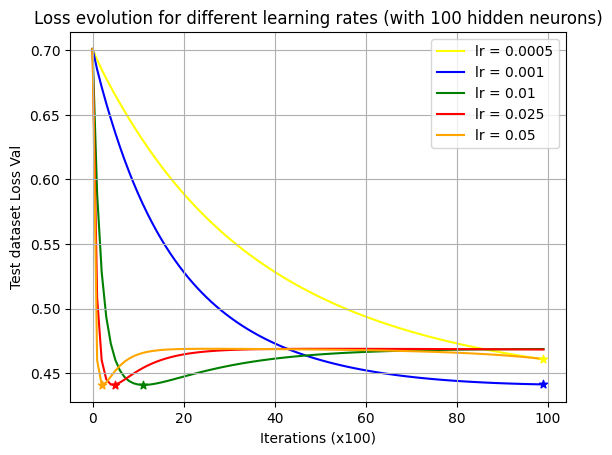

In [24]:
best_hidden_neurons = 100
learning_rates = [0.0005, 0.001, 0.01, 0.025, 0.05]

print("\n\nTests for different learning rates:")
fig10 = plt.figure(10)
for lr, color in zip(learning_rates, custom_colors):
    torch.manual_seed(seed_value)
    curr_NN = MLP_PyTorch(hiddenNode=best_hidden_neurons)
    curr_optimizer = torch.optim.SGD(curr_NN.parameters(), lr=lr, momentum=0) 
    torch_train_list_loss, torch_test_list_loss, train_time, _ = train_PyTorch(
        curr_NN,
        torch.from_numpy(X_train_norm).type(curr_NN.parameters().__next__().dtype),
        torch.from_numpy(X_test_norm).type(curr_NN.parameters().__next__().dtype),
        torch.from_numpy(C_train).type(curr_NN.parameters().__next__().dtype),
        torch.from_numpy(C_test).type(curr_NN.parameters().__next__().dtype),
        optimizer = curr_optimizer,
        lr = lr
    )   
    
    argmin = torch_test_list_loss.index(min(torch_test_list_loss))
    print(f"\t{lr} lr: Iterations to min error ({torch_test_list_loss[argmin]}): {argmin}. Time to min error: {train_time[argmin]}(s)")
    plt.scatter(argmin, torch_test_list_loss[argmin], color = color, marker="*", zorder = 2)
    plt.plot(torch_test_list_loss, color = color, label = f"lr = {lr}", zorder = 1)

plt.title(f"Loss evolution for different learning rates (with {best_hidden_neurons} hidden neurons)")
plt.xlabel('Iterations (x100)')
plt.ylabel('Test dataset Loss Val')
plt.legend()
plt.grid()
if save_figure:
    plt.savefig(f"{results_path}/fig10.png", dpi=300)
plt.show()

### Accuracy

In [25]:
final_NN = MLP_PyTorch(hiddenNode=best_hidden_neurons) 
final_optimizer = torch.optim.SGD(final_NN.parameters(), lr=.05, momentum=0.9) 

_, __, ___, ____ = train_PyTorch(
        final_NN,
        torch.from_numpy(X_train_norm).type(final_NN.parameters().__next__().dtype),
        torch.from_numpy(X_test_norm).type(final_NN.parameters().__next__().dtype),
        torch.from_numpy(C_train).type(final_NN.parameters().__next__().dtype),
        torch.from_numpy(C_test).type(final_NN.parameters().__next__().dtype),
        optimizer = final_optimizer,
        lr = .05
    )   



output_test = torch_classify(final_NN, X_test_norm)
output_train = torch_classify(final_NN, X_train_norm)
                                
torch_train_accuracy = binary_classification_accuracy(X_train_norm, C_train, output_train)
print(f"\nTrain accuracy: {torch_train_accuracy*100}%")

torch_test_accuracy = binary_classification_accuracy(X_test_norm, C_test, output_test)
print(f"\nTest accuracy: {torch_test_accuracy*100}%")


Train accuracy: 98.0%

Test accuracy: 92.0%
